## Auto-Encoders based multilabel target classification
* Autoencoders are designed to learn efficient representations of input data, by encoding the input data into a lower-dimensional representation and then decoding the representation back into the original input data. 

- Prior to learning efficent features through autoencoders, data containing cell viability and gene expression features are standardized with standard scaler to speed up the process of model training.

In [ ]:
# installation of library for cross validation of multilabel data

!pip3 install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing the necessary libraries/modules


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers,regularizers,Sequential,backend,callbacks,optimizers,metrics, Model,losses
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [ ]:
# downloading the kaggle dataset on google colab, then unzipping the data

import os

os.environ['KAGGLE_USERNAME'] = "rajahussain53" # username from the json file
os.environ['KAGGLE_KEY'] = "6cc52f97629ff7e62574e4eb789b54a8" # key from the json file
!kaggle competitions download -c lish-moa

!unzip /content/lish-moa.zip
!rm /content/lish-moa.zip

 94% 61.0M/64.7M [00:02<00:00, 32.4MB/s]
100% 64.7M/64.7M [00:02<00:00, 24.7MB/s]
Archive:  /content/lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


In [ ]:
# reading the training data

train_features = pd.read_csv('/content/train_features.csv')
treatment_cp_val = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type'],axis=1)  # dropping two columns: drugs id, compound type
train_targets_scored = pd.read_csv('/content/train_targets_scored.csv')
train_targets_scored = train_targets_scored.drop('sig_id',axis=1)  # dropping drugs id column
train_label = train_targets_scored.values

# Droping of training data with ctl_vehicle

train_features = train_features.iloc[treatment_cp_val]
train_label = train_label[treatment_cp_val]

# Importing test data

test_features = pd.read_csv('/content/test_features.csv')
test_features = test_features.drop(['sig_id'],axis=1)

In [ ]:
train_features

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23808,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,-0.1777,...,0.0789,0.3538,0.0558,0.3377,-0.4753,-0.2504,-0.7415,0.8413,-0.4259,0.2434
23809,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23812,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [ ]:
# Label Encoding technique to assign integer values to categorical feature "cp_dose"

categorical = 'cp_dose'
le = preprocessing.LabelEncoder()
le.fit(train_features[categorical])
train_features[categorical] = le.transform(train_features[categorical])

# apply same label encoding technique to transform categorical feature for test dataset 

test_features[categorical] = le.transform(test_features[categorical])

**Pre-processing data** 

- Quantile Transformer is a type of data transformation technique to non-linearly transform skewed distribution of cell viability and genes expressions to gaussian distribution. Scaling is performed to transform the data into particular range.

- standard scalar method is applied to transform and standardize `cp_time` and `cp_dose`

In [ ]:
# Quantile Transformer for gene and cell features

scaler = preprocessing.QuantileTransformer(output_distribution='normal')

# Scaling of train data
data_train = scaler.fit_transform(train_features.iloc[:,2:])

# Scaling of test data
data_test = scaler.transform(test_features.drop('cp_type',axis=1).iloc[:,2:])

# Standard Scaling for Dose/Time

scaler = preprocessing.StandardScaler()

# Concatinating train & test feature

data_train =  np.concatenate((scaler.fit_transform(train_features.iloc[:,:2]),data_train),axis=1)
data_test =  np.concatenate((scaler.transform(test_features.drop('cp_type',axis=1).iloc[:,:2]),data_test),axis=1)

In [ ]:
print(f'n_train_features: {data_train.shape[1]}, n_train_labels: {train_label.shape[1]}')
print(f'n_train_instances: {data_train.shape[0]}, n_test_instances: {data_test.shape[0]}')

n_train_features: 874, n_train_labels: 206
n_train_instances: 21948, n_test_instances: 3982


In [ ]:
#X_train, y_train = data_train[:17558,], train_label[:17558,]  # 
#X_val, y_val = data_train[17558:,], train_label[17558:,]

In [ ]:
#c_f = train_features.drop(['sig_id','cp_type'],axis=1).columns.str.contains('c-')

c_f = train_features.columns.str.contains('c-')
cells_train = data_train[:,c_f]

cells_train.shape

(21948, 100)

In [ ]:
# Autoencoder to represent the data with compressed and efficent features

# representing the cell data in low-dimensional space
c_feat = train_features.columns.str.contains('c-')
cells_train = data_train[:,c_feat]
cells_test = data_test[:,c_feat]
dim_encd = 50
class Autoencoder(Model):
    def __init__(self, sample_dim, dim_encd):
        super(Autoencoder, self).__init__()
        # encoder layout
        self.encoder = Sequential([             
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(0.5*dim_encd,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(0.75*dim_encd,activation= 'relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(dim_encd,activation='relu'),
        ])
        # decoder layout
        self.decoder = Sequential([
            layers.Dense(0.75*dim_encd,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(0.5*dim_encd,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(sample_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
cell_auto_encd = Autoencoder(c_feat.sum(),dim_encd)
cell_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss='mse')
ae_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1E-5)
ae_early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=16, restore_best_weights=True)
def scheduler(epoch,lr):
    if epoch%30<17:
        lr += (0.3*1E-2)/15
    else:
        lr -= (0.3*1E-2)/15
    return lr

lr_scheduler = callbacks.LearningRateScheduler(scheduler)
hist = cell_auto_encd.fit(cells_train,cells_train,batch_size=128, verbose=1, 
                          validation_data = (cells_test,cells_test), epochs=200, 
                          shuffle=True, callbacks=[ae_early_stopping,lr_scheduler])

cell_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=5*1E-5), loss='mse')



Epoch 1/200
172/172 [==============================] - 4s 6ms/step - loss: 1.2442 - val_loss: 0.8029 - lr: 2.1000e-04
Epoch 2/200
172/172 [==============================] - 1s 5ms/step - loss: 0.7357 - val_loss: 0.6434 - lr: 4.1000e-04
Epoch 3/200
172/172 [==============================] - 1s 4ms/step - loss: 0.6257 - val_loss: 0.5720 - lr: 6.1000e-04
Epoch 4/200
172/172 [==============================] - 1s 4ms/step - loss: 0.6088 - val_loss: 0.5420 - lr: 8.1000e-04
Epoch 5/200
172/172 [==============================] - 1s 4ms/step - loss: 0.5956 - val_loss: 0.5378 - lr: 0.0010
Epoch 6/200
172/172 [==============================] - 1s 4ms/step - loss: 0.5876 - val_loss: 0.5340 - lr: 0.0012
Epoch 7/200
172/172 [==============================] - 1s 4ms/step - loss: 0.5770 - val_loss: 0.5308 - lr: 0.0014
Epoch 8/200
172/172 [==============================] - 1s 5ms/step - loss: 0.5683 - val_loss: 0.5217 - lr: 0.0016
Epoch 9/200
172/172 [==============================] - 1s 4ms/step - los

In [ ]:
cell_auto_encd.fit(cells_train,cells_train,batch_size=128, verbose=1, 
                   validation_data = (cells_test,cells_test), epochs=200, 
                   shuffle=True, callbacks=[ae_early_stopping,ae_reduce_lr])
cell_auto_encd.save('cell_fet_auto_encd')

Epoch 1/200
172/172 [==============================] - 3s 5ms/step - loss: 0.4940 - val_loss: 0.4541 - lr: 5.0000e-05
Epoch 2/200
172/172 [==============================] - 1s 4ms/step - loss: 0.4919 - val_loss: 0.4551 - lr: 5.0000e-05
Epoch 3/200
172/172 [==============================] - 1s 4ms/step - loss: 0.4925 - val_loss: 0.4537 - lr: 5.0000e-05
Epoch 4/200
172/172 [==============================] - 1s 5ms/step - loss: 0.4908 - val_loss: 0.4548 - lr: 5.0000e-05
Epoch 5/200
172/172 [==============================] - 1s 5ms/step - loss: 0.4920 - val_loss: 0.4541 - lr: 5.0000e-05
Epoch 6/200
172/172 [==============================] - 1s 4ms/step - loss: 0.4906 - val_loss: 0.4532 - lr: 5.0000e-05
Epoch 7/200
172/172 [==============================] - 1s 4ms/step - loss: 0.4928 - val_loss: 0.4537 - lr: 5.0000e-05
Epoch 8/200
172/172 [==============================] - 1s 4ms/step - loss: 0.4916 - val_loss: 0.4521 - lr: 5.0000e-05
Epoch 9/200
172/172 [==============================] - 1

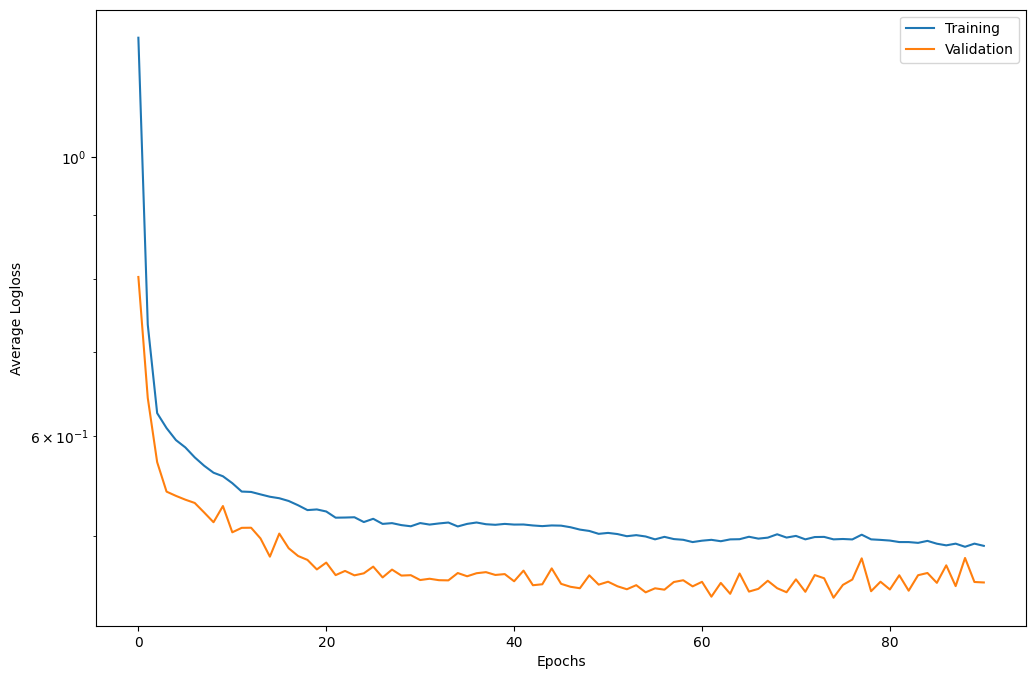

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [ ]:
# Genes feature i.e. 'g-'
g_feat = train_features.columns.str.contains('g-')
genes_train = data_train[:,g_feat]
genes_test = data_test[:,g_feat]
dim_enc = 400
noise = 0.15
dropout = 0.1
class Autoencoder(Model):
    def __init__(self, num_inp, dim_enc):
        super(Autoencoder, self).__init__()
        # encoder function
        self.encoder = Sequential([
            layers.BatchNormalization(),
            layers.Dropout(noise),
            layers.Dense(0.5*dim_enc,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.75*dim_enc,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(dim_enc,activation='relu'),
        ])
        # decoder function
        self.decoder = Sequential([
            layers.Dense(0.75*dim_enc,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(0.5*dim_enc,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout),
            layers.Dense(num_inp)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
gene_auto_encd = Autoencoder(g_feat.sum(),dim_enc)
gene_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss='mse')
ae_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1E-5)
ae_early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=16, restore_best_weights=True)

hist = gene_auto_encd.fit(genes_train,genes_train,batch_size=128, verbose=1, 
                          validation_data = (genes_test,genes_test), epochs=200, 
                          shuffle=True, callbacks=[ae_early_stopping,lr_scheduler])

gene_auto_encd.compile(optimizer=optimizers.Adam(learning_rate=5*1E-5), loss='mse')
gene_auto_encd.fit(genes_train,genes_train,batch_size=128, verbose=1, 
                   validation_data = (genes_test,genes_test), epochs=200, 
                   shuffle=True, callbacks=[ae_early_stopping])
gene_auto_encd.save('gene_fet_auto_encd')

Epoch 1/200
172/172 [==============================] - 7s 24ms/step - loss: 1.0065 - val_loss: 0.7812 - lr: 2.1000e-04
Epoch 2/200
172/172 [==============================] - 4s 23ms/step - loss: 0.7640 - val_loss: 0.6781 - lr: 4.1000e-04
Epoch 3/200
172/172 [==============================] - 4s 25ms/step - loss: 0.6982 - val_loss: 0.6197 - lr: 6.1000e-04
Epoch 4/200
172/172 [==============================] - 4s 23ms/step - loss: 0.6573 - val_loss: 0.5864 - lr: 8.1000e-04
Epoch 5/200
172/172 [==============================] - 4s 22ms/step - loss: 0.6259 - val_loss: 0.5656 - lr: 0.0010
Epoch 6/200
172/172 [==============================] - 5s 26ms/step - loss: 0.6023 - val_loss: 0.5501 - lr: 0.0012
Epoch 7/200
172/172 [==============================] - 4s 23ms/step - loss: 0.5847 - val_loss: 0.5392 - lr: 0.0014
Epoch 8/200
172/172 [==============================] - 4s 22ms/step - loss: 0.5727 - val_loss: 0.5267 - lr: 0.0016
Epoch 9/200
172/172 [==============================] - 4s 26ms/s

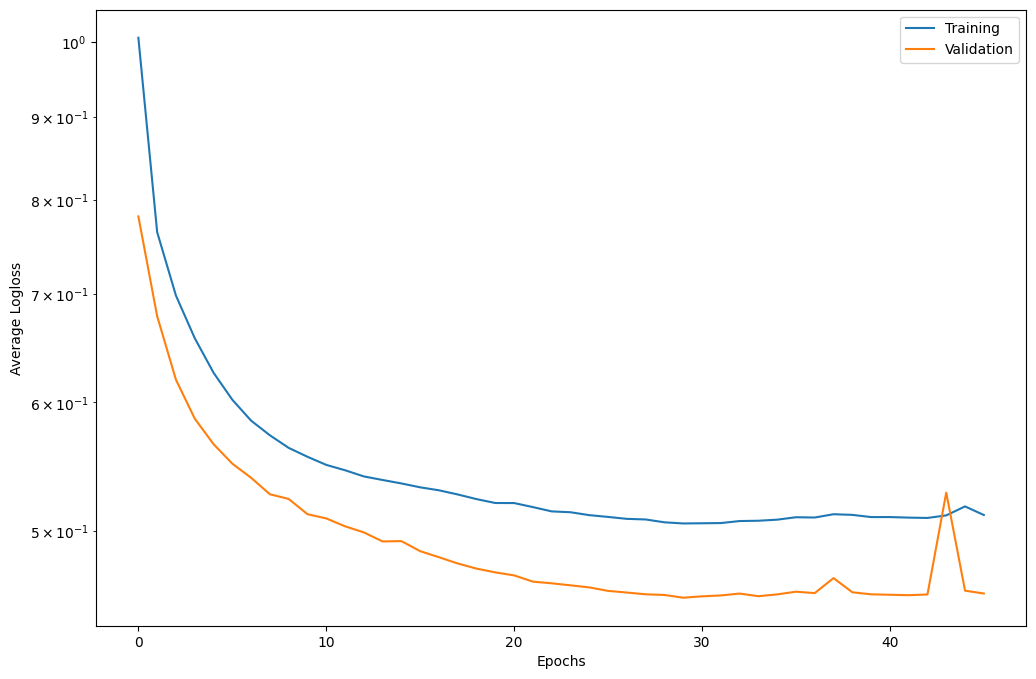

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [ ]:
ae_cells_train = cell_auto_encd.encoder(cells_train).numpy()
ae_cells_test = cell_auto_encd.encoder(cells_test).numpy()
autoencoder_error = mean_squared_error(cells_test,cell_auto_encd.decoder(ae_cells_test).numpy())
print("Cells reconstruction error is " + str(autoencoder_error))

Cells reconstruction error is 0.4508730340116873


In [ ]:
# Comparison with PCA
pca = PCA(n_components=50)
pca.fit(cells_train)
pca_error = mean_squared_error(cells_test,pca.inverse_transform(pca.transform(cells_test)))
print('PCA Reconstruction Error for Cells is ' + str(pca_error))

PCA Reconstruction Error for Cells is 0.21735183622824197


* Autoencoders performs well for cell features

In [ ]:
ae_genes_train = gene_auto_encd.encoder(genes_train).numpy()
ae_genes_test = gene_auto_encd.encoder(genes_test).numpy()
autoencoder_error = mean_squared_error(genes_test,gene_auto_encd.decoder(ae_genes_test).numpy())
print("Genes reconstruction error is " + str(autoencoder_error))

Genes reconstruction error is 0.4454641975612238


In [ ]:
data_train.shape, data_test.shape

((21948, 874), (3982, 874))

In [ ]:
# Replacing the data with auto_encoded features data
data_train = np.concatenate((data_train[:,~(c_feat+g_feat)],ae_genes_train,ae_cells_train),axis=1)
data_test = np.concatenate((data_test[:,~(c_feat+g_feat)],ae_genes_test,ae_cells_test),axis=1)

In [ ]:
import pickle
# saving the model to the local file system


In [ ]:
data_train.shape, data_test.shape


((21948, 452), (3982, 452))

In [ ]:
num_of_lab = train_targets_scored.shape[1]
# num_of_feat = data_train.shape[1]
# n_train = data_train.shape[0]
final_test = data_test.shape[0]


# Predicting Thresholds

p_min = 0.0005
p_max = 0.9995

# Evaluation Metric

# here we uses logloss as the given kaggle dataset asked for performing a logloss metrices

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

# Generating Seeds

num_of_seeds = 3
seeds = [34,9,18]

# Training Loop

num_of_folds = 5
y_pred = np.zeros((final_test,num_of_lab))
oof = tf.constant(0.0)
hists = []
bias = tf.keras.initializers.Constant(np.log(train_label.mean(axis=0)))
for seed in seeds:
    fold = 0
    mskf = MultilabelStratifiedKFold(n_splits=num_of_folds,shuffle=True,random_state=seed)
    for train, test in mskf.split(data_train,train_label):
        X_train = data_train[train]
        X_test = data_train[test]
        y_train = train_label[train]
        y_test = train_label[test]

        # Building Neural Network Model
        model = Sequential([
            layers.Dropout(0.3),
            layers.Dense(1536,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.7),
            layers.Dense(1024,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(512,activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(num_of_lab,activation='sigmoid',bias_initializer=bias)

        ])

        model.compile(optimizer=optimizers.Adam(learning_rate=1E-5), loss=losses.BinaryCrossentropy(label_smoothing=0.001), metrics=['binary_crossentropy',logloss])
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.3, patience=5, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=24, mode='min',restore_best_weights=True)
        def scheduler(epoch,lr):
            if epoch%16<9:
                lr += np.exp(-int(epoch/16))*(0.5*1E-2)/16
            else:
                lr -= np.exp(-int(epoch/16))*(0.5*1E-2)/16
            return lr

        lr_scheduler = callbacks.LearningRateScheduler(scheduler)
        hist = model.fit(X_train,y_train, batch_size=128, epochs=10,
                         verbose=1,validation_data = (X_test,y_test),
                         callbacks=[lr_scheduler, early_stopping])
        
        model.compile(optimizer=optimizers.Adam(learning_rate=1E-5), 
                      loss=losses.BinaryCrossentropy(label_smoothing=0.001), 
                      metrics=['binary_crossentropy',logloss])
        model.fit(X_train,y_train, batch_size=128, 
                  epochs=10,verbose=1,validation_data = (X_test,y_test),
                  callbacks=[early_stopping])

        hists.append(hist)
        
        # Save Model
        model.save('AutoEncoded_seed_'+str(seed)+'_fold_'+str(fold))
        
        #Creating pickle file
        filename = 'AutoEncoded_seed_'+str(seed)+'_fold_'+str(fold)+'.pickle'
        pickle.dump(model, open(filename, 'wb'))

        # OOF Score
        y_val = model.predict(X_test)
        oof += logloss(tf.constant(y_test,dtype=tf.float32),
                       tf.constant(y_val,dtype=tf.float32))/(num_of_folds*num_of_seeds)

        # Run prediction
        y_pred += model.predict(data_test)/(num_of_folds*num_of_seeds)

        fold += 1

Epoch 1/10
138/138 [==============================] - 12s 74ms/step - loss: 0.0280 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0230 - val_binary_crossentropy: 0.0200 - val_logloss: 0.0199 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0245 - binary_crossentropy: 0.0213 - logloss: 0.0213 - val_loss: 0.0223 - val_binary_crossentropy: 0.0193 - val_logloss: 0.0192 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 9s 68ms/step - loss: 0.0229 - binary_crossentropy: 0.0197 - logloss: 0.0197 - val_loss: 0.0217 - val_binary_crossentropy: 0.0185 - val_logloss: 0.0184 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0221 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0213 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0180 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0217 - binary_crossentropy: 0.0184 

125/125 [==============================] - 1s 8ms/step
Epoch 1/10
138/138 [==============================] - 12s 74ms/step - loss: 0.0279 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0231 - val_binary_crossentropy: 0.0201 - val_logloss: 0.0201 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0243 - binary_crossentropy: 0.0212 - logloss: 0.0211 - val_loss: 0.0226 - val_binary_crossentropy: 0.0195 - val_logloss: 0.0195 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 9s 67ms/step - loss: 0.0229 - binary_crossentropy: 0.0196 - logloss: 0.0197 - val_loss: 0.0219 - val_binary_crossentropy: 0.0187 - val_logloss: 0.0187 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0221 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0215 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0183 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s 

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 12s 76ms/step - loss: 0.0279 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0228 - val_binary_crossentropy: 0.0199 - val_logloss: 0.0198 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 73ms/step - loss: 0.0244 - binary_crossentropy: 0.0212 - logloss: 0.0212 - val_loss: 0.0222 - val_binary_crossentropy: 0.0191 - val_logloss: 0.0191 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 11s 78ms/step - loss: 0.0229 - binary_crossentropy: 0.0197 - logloss: 0.0197 - val_loss: 0.0216 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0222 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0213 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0180 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 12s 73ms/step - loss: 0.0279 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0229 - val_binary_crossentropy: 0.0199 - val_logloss: 0.0199 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0244 - binary_crossentropy: 0.0213 - logloss: 0.0212 - val_loss: 0.0222 - val_binary_crossentropy: 0.0191 - val_logloss: 0.0191 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0230 - binary_crossentropy: 0.0198 - logloss: 0.0198 - val_loss: 0.0214 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0183 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0222 - binary_crossentropy: 0.0190 - logloss: 0.0189 - val_loss: 0.0210 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0178 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 12s 73ms/step - loss: 0.0280 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0229 - val_binary_crossentropy: 0.0199 - val_logloss: 0.0199 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0245 - binary_crossentropy: 0.0213 - logloss: 0.0212 - val_loss: 0.0224 - val_binary_crossentropy: 0.0193 - val_logloss: 0.0193 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0229 - binary_crossentropy: 0.0197 - logloss: 0.0196 - val_loss: 0.0217 - val_binary_crossentropy: 0.0186 - val_logloss: 0.0185 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0222 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0212 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0180 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 12s 71ms/step - loss: 0.0279 - binary_crossentropy: 0.0247 - logloss: 0.0246 - val_loss: 0.0229 - val_binary_crossentropy: 0.0200 - val_logloss: 0.0200 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0243 - binary_crossentropy: 0.0212 - logloss: 0.0212 - val_loss: 0.0224 - val_binary_crossentropy: 0.0193 - val_logloss: 0.0193 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0228 - binary_crossentropy: 0.0196 - logloss: 0.0196 - val_loss: 0.0216 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 72ms/step - loss: 0.0221 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0213 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0181 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 13s 79ms/step - loss: 0.0280 - binary_crossentropy: 0.0248 - logloss: 0.0247 - val_loss: 0.0229 - val_binary_crossentropy: 0.0199 - val_logloss: 0.0199 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0244 - binary_crossentropy: 0.0213 - logloss: 0.0212 - val_loss: 0.0223 - val_binary_crossentropy: 0.0193 - val_logloss: 0.0193 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0229 - binary_crossentropy: 0.0197 - logloss: 0.0197 - val_loss: 0.0217 - val_binary_crossentropy: 0.0185 - val_logloss: 0.0185 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 71ms/step - loss: 0.0222 - binary_crossentropy: 0.0190 - logloss: 0.0190 - val_loss: 0.0213 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0180 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

125/125 [==============================] - 1s 7ms/step
Epoch 1/10
138/138 [==============================] - 12s 77ms/step - loss: 0.0278 - binary_crossentropy: 0.0247 - logloss: 0.0246 - val_loss: 0.0230 - val_binary_crossentropy: 0.0200 - val_logloss: 0.0200 - lr: 3.2250e-04
Epoch 2/10
138/138 [==============================] - 10s 69ms/step - loss: 0.0243 - binary_crossentropy: 0.0212 - logloss: 0.0212 - val_loss: 0.0225 - val_binary_crossentropy: 0.0194 - val_logloss: 0.0193 - lr: 6.3500e-04
Epoch 3/10
138/138 [==============================] - 10s 73ms/step - loss: 0.0228 - binary_crossentropy: 0.0196 - logloss: 0.0197 - val_loss: 0.0217 - val_binary_crossentropy: 0.0185 - val_logloss: 0.0185 - lr: 9.4750e-04
Epoch 4/10
138/138 [==============================] - 10s 73ms/step - loss: 0.0221 - binary_crossentropy: 0.0189 - logloss: 0.0189 - val_loss: 0.0215 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0182 - lr: 0.0013
Epoch 5/10
138/138 [==============================] - 10s

OOF score is  0.0170850251


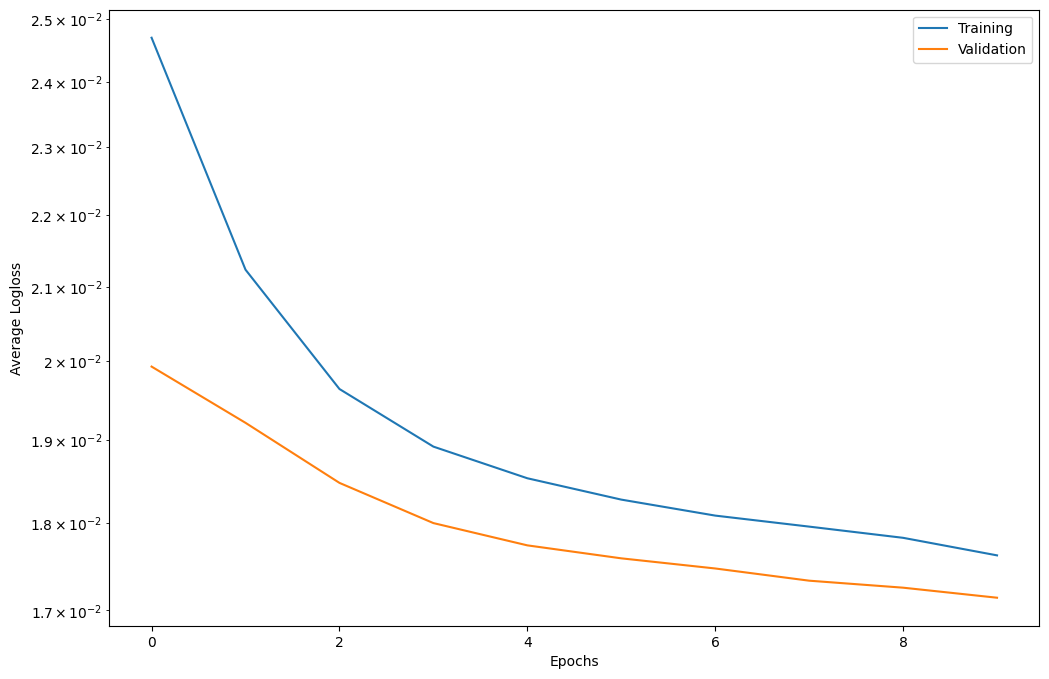

In [ ]:
# Analysis of Training

tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(num_of_folds*num_of_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(num_of_folds*num_of_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(num_of_folds*num_of_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(num_of_folds*num_of_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [ ]:
p_min = 0.0005
p_max = 0.9995

# Generate submission file, Clip Predictions

sub = pd.read_csv('/content/sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('/content/submission.csv', index=False)

![](kaggle_score.png)